In [95]:
import warnings
warnings.filterwarnings('ignore')

In [104]:
%matplotlib inline

from tqdm import tqdm
from itertools import product
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

expire_after = datetime.timedelta(days=5)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)
session.headers = DEFAULT_HEADERS

In [8]:
sns.set_style('whitegrid')

In [9]:
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    with sns.axes_style('whitegrid'):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
        x.plot(ax=axes[0][0], title='Residuals')
        x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
        q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
        stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
        axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
        probplot(x, plot=axes[0][1])
        mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
        s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
        axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
        plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
        plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
        axes[1][0].set_xlabel('Lag')
        axes[1][1].set_xlabel('Lag')
        fig.suptitle(title, fontsize=14)
        sns.despine()
        fig.tight_layout()
        fig.subplots_adjust(top=.9)

In [ ]:
def prediction_plot(model, actuals, predictions):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
    actuals.plot(ax=axes,
                title=f'{model} Predictions',label='Actuals')

    predictions.plot(ax=axes,label='Predictions')
    axes.legend()

##### Load monthly industrial production and daily NASDAQ stock market index:

In [44]:
# industrial_production = web.DataReader('IPGMFN', 'fred', '1988', '2023-12-31', session=session).squeeze().dropna()
# nasdaq = web.DataReader('NASDAQCOM', 'fred', '1990', '2023-12-31', session=session).squeeze().dropna()

industrial_production = pd.read_csv("industrial_production_1988_2023.csv")
nasdaq = pd.read_csv("nasdaq_1990_2023.csv")

industrial_production = industrial_production.set_index("DATE")
nasdaq = nasdaq.set_index("DATE")

industrial_production = industrial_production['IPGMFN']
nasdaq = nasdaq['NASDAQCOM']


In [34]:
#One time storage

# nasdaq_df = pd.DataFrame(nasdaq)
# industrial_production_df = pd.DataFrame(industrial_production)

# nasdaq_df.to_csv("nasdaq_1990_2023.csv")
# industrial_production_df.to_csv("industrial_production_1988_2023.csv")

In [46]:
nasdaq

DATE
1990-01-02      459.33
1990-01-03      460.90
1990-01-04      459.39
1990-01-05      458.22
1990-01-08      458.71
                ...   
2023-12-22    14992.97
2023-12-26    15074.57
2023-12-27    15099.18
2023-12-28    15095.14
2023-12-29    15011.35
Name: NASDAQCOM, Length: 8566, dtype: float64

##### Log transformation and Differencing

In [47]:
nasdaq_diff = nasdaq.diff().dropna()
industrial_production_diff = industrial_production.diff().dropna()

In [48]:
nasdaq_log = np.log(nasdaq)
industrial_production_log = np.log(industrial_production)

In [49]:
nasdaq_log_diff = nasdaq_log.diff().dropna()
industrial_production_log_diff = industrial_production_log.diff(periods=12).dropna()

##### ARMA vs ARIMA

In [86]:
model1 = tsa.arima.ARIMA(endog = nasdaq_log_diff, order = (4, 0, 9)).fit()
# model2 = tsa.arima.ARIMA(endog = nasdaq_log, order = (2, 1, 2)).fit()

c:\Personal\time-series\time_series_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Personal\time-series\time_series_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Personal\time-series\time_series_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


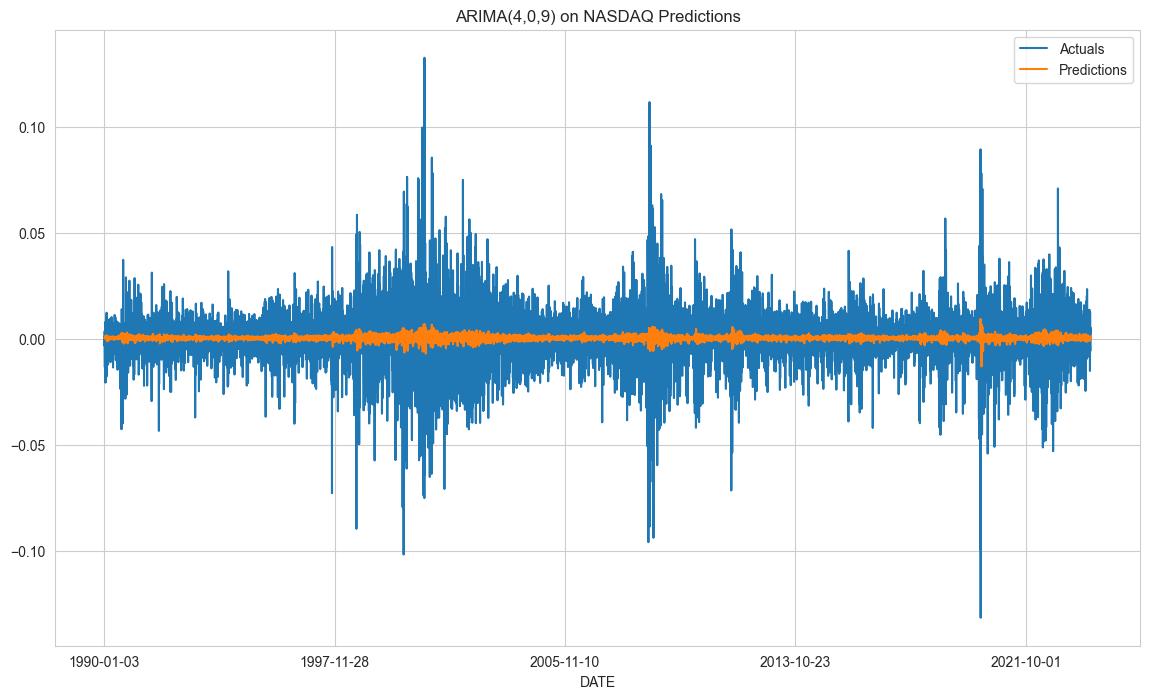

In [87]:
predictions = model1.predict()
prediction_plot('ARIMA(4,0,9) on NASDAQ',nasdaq_log_diff, predictions)

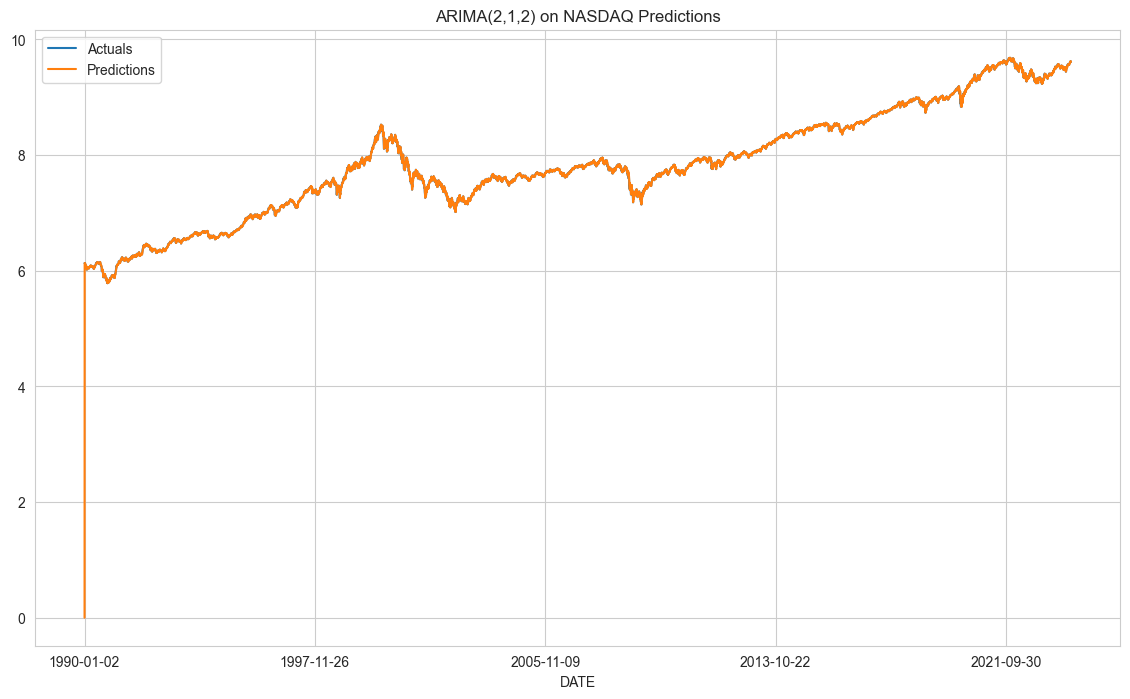

In [83]:
predictions = model2.predict()
prediction_plot("ARIMA(2,1,2) on NASDAQ", nasdaq_log, predictions)

##### Seasonal Differencing vs SARIMAX

In [93]:
model1 = tsa.statespace.SARIMAX(industrial_production_log, order=(2,0,2), seasonal_order=(0,1,0,12)).fit()
model2 = tsa.statespace.SARIMAX(industrial_production_log_diff, order=(2,0,2), seasonal_order=(0,0,0,12)).fit()
model3 = tsa.arima.ARIMA(industrial_production_log_diff, order=(2,0,2)).fit()

c:\Personal\time-series\time_series_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Personal\time-series\time_series_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Personal\time-series\time_series_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Personal\time-series\time_series_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Personal\time-series\time_series_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: 

In [94]:
model1.params.to_frame('sarima on IP log').join(model2.params.to_frame('sarima with no diff on IP log diff')).join(model3.params.to_frame('arima on IP log diff'))

,sarima on IP log,sarima with no diff on IP log diff,arima on IP log diff
ar.L1,0.865985,0.865985,0.888608
ar.L2,0.061464,0.061464,0.033187
ma.L1,0.226598,0.226599,0.200003
ma.L2,-0.114211,-0.114211,-0.115598
sigma2,0.000317,0.000317,0.000316


My notes: This is what is given in the github, but technically we are simply doing a SARIMA only on industrial production log with a differencing of 1 every 12 months and comparing it with the differenced logs on IP

In [105]:
train_size = 120
results = {}
y_true = industrial_production_log_diff.iloc[train_size:]
train_set = industrial_production_log_diff.iloc[:train_size]
model = tsa.arima.ARIMA(endog=train_set, order=(0, 0, 0)).fit()
model.forecast(1)
model.aic

-479.06641487201455

In [109]:
train_size = 120
results = {}
y_true = industrial_production_log_diff.iloc[train_size:]
for p in tqdm(range(5), position=0, leave=True):
    for d in tqdm(range(2), position=0, leave=True):
        for q in tqdm(range(5), position=0, leave=True):
            aic, bic = [], []
            if p == 0 and q == 0 and d == 0:
                continue
            print(p, d, q)
            convergence_error = stationarity_error = 0
            y_pred = []
            for T in range(train_size, len(industrial_production_log_diff)):
                train_set = industrial_production_log_diff.iloc[T-train_size:T]
                try:
                    model = tsa.arima.ARIMA(endog=train_set, order=(p, d, q)).fit()
                except LinAlgError:
                    convergence_error += 1
                except ValueError:
                    stationarity_error += 1

                forecast= model.forecast(steps=1)
                y_pred.append(forecast[0])
                aic.append(model.aic)
                bic.append(model.bic)
                print(aic)
                
            print(np.mean(aic))
            result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
                    .replace(np.inf, np.nan)
                    .dropna())

            rmse = np.sqrt(mean_squared_error(
                y_true=result.y_true, y_pred=result.y_pred))

            results[(p, q)] = [rmse,
                            np.mean(aic),
                            np.mean(bic),
                            convergence_error,
                            stationarity_error]

  0%|          | 0/5 [00:00<?, ?it/s]

0 0 1
[-590.9261355600926]
[-590.9261355600926, -591.2658496789876]
[-590.9261355600926, -591.2658496789876, -591.6172520753012]
[-590.9261355600926, -591.2658496789876, -591.6172520753012, -593.9289518419176]
[-590.9261355600926, -591.2658496789876, -591.6172520753012, -593.9289518419176, -593.5649851258278]
[-590.9261355600926, -591.2658496789876, -591.6172520753012, -593.9289518419176, -593.5649851258278, -594.8843285297742]
[-590.9261355600926, -591.2658496789876, -591.6172520753012, -593.9289518419176, -593.5649851258278, -594.8843285297742, -593.6404551636684]
[-590.9261355600926, -591.2658496789876, -591.6172520753012, -593.9289518419176, -593.5649851258278, -594.8843285297742, -593.6404551636684, -595.2124649565346]
[-590.9261355600926, -591.2658496789876, -591.6172520753012, -593.9289518419176, -593.5649851258278, -594.8843285297742, -593.6404551636684, -595.2124649565346, -596.092213586991]
[-590.9261355600926, -591.2658496789876, -591.6172520753012, -593.9289518419176, -593.

  0%|          | 0/5 [00:47<?, ?it/s]


KeyboardInterrupt: 